 # HoVerNet - The CoNIC Baseline

## About this notebook
In this notebook, we provide a pretrained
[HoVerNet](https://arxiv.org/abs/1812.06499)
as the baseline model for the CoNIC training data.
The HoVerNet utilized here was trained using
only data from the CoNIC training set. You can download the pretrained
weights [here](https://drive.google.com/file/d/1oVCD4_kOS-8Wu-eS5ZqzE30F9V3Id78d/view?usp=sharing).

In the making of the baseline model, we perform following steps:
- Generating training and validation split.
- Perform the inference to get raw output.
- Perform the post-processing to convert the output into an approriate form
for the evaluation process in `compute_stats.py`.

All in all, the HoVerNet trained on the data split obtained
from this notebook achieved the validation results as follows:

**Nucleus Instance Segmentation and Classification**
---------------------------
| PQ     | mPQ<sup>+</sup>|
|--------|----------------|
| 0.6149 | 0.4998         |
---------------------------


**Cell Composition**
-----------------
| R<sup>2</sup> |
|---------------|
| 0.8585        |
-----------------

 ## Importing Libraries and Workspace Settings
 We import some Python modules that are utilised throughout the notebook.

 > **Note**: We use `tiatoolbox` extensively in this repository.
 > You can refer to [here](https://github.com/TissueImageAnalytics/tiatoolbox) for installation instructions.
 > For this notebook, we use the `develop` branch rather than `master`.

 We also declare the folders which contain the input
 data and the output.

In [ ]:
# run in Console
# !apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools

In [ ]:
!pip install tiatoolbox

In [1]:
import numpy as np
import pathlib
import os
import shutil


def remap_label(pred, by_size=False):
    """Rename all instance id so that the id is contiguous i.e [0, 1, 2, 3] 
    not [0, 2, 4, 6]. The ordering of instances (which one comes first) 
    is preserved unless by_size=True, then the instances will be reordered
    so that bigger nucler has smaller ID.

    Args:
        pred (ndarray): the 2d array contain instances where each instances is marked
            by non-zero integer.
        by_size (bool): renaming such that larger nuclei have a smaller id (on-top).

    Returns:
        new_pred (ndarray): Array with continguous ordering of instances.

    """
    pred_id = list(np.unique(pred))
    pred_id.remove(0)
    if len(pred_id) == 0:
        return pred  # no label
    if by_size:
        pred_size = []
        for inst_id in pred_id:
            size = (pred == inst_id).sum()
            pred_size.append(size)
        # sort the id by size in descending order
        pair_list = zip(pred_id, pred_size)
        pair_list = sorted(pair_list, key=lambda x: x[1], reverse=True)
        pred_id, pred_size = zip(*pair_list)

    new_pred = np.zeros(pred.shape, np.int32)
    for idx, inst_id in enumerate(pred_id):
        new_pred[pred == inst_id] = idx + 1
    return new_pred


def cropping_center(x, crop_shape, batch=False):
    """Crop an array at the centre with specified dimensions."""
    orig_shape = x.shape
    if not batch:
        h0 = int((orig_shape[0] - crop_shape[0]) * 0.5)
        w0 = int((orig_shape[1] - crop_shape[1]) * 0.5)
        x = x[h0 : h0 + crop_shape[0], w0 : w0 + crop_shape[1]]
    else:
        h0 = int((orig_shape[1] - crop_shape[0]) * 0.5)
        w0 = int((orig_shape[2] - crop_shape[1]) * 0.5)
        x = x[:, h0 : h0 + crop_shape[0], w0 : w0 + crop_shape[1]]
    return x


def rm_n_mkdir(dir_path):
    """Remove and make directory."""
    if os.path.isdir(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)


def rmdir(dir_path):
    if os.path.isdir(dir_path):
        shutil.rmtree(dir_path)
    return


def recur_find_ext(root_dir, ext_list):
    """Recursively find all files in directories end with the `ext` such as `ext='.png'`.

    Args:
        root_dir (str): Root directory to grab filepaths from.
        ext_list (list): File extensions to consider.

    Returns:
        file_path_list (list): sorted list of filepaths.
    """
    file_path_list = []
    for cur_path, dir_list, file_list in os.walk(root_dir):
        for file_name in file_list:
            file_ext = pathlib.Path(file_name).suffix
            if file_ext in ext_list:
                full_path = os.path.join(cur_path, file_name)
                file_path_list.append(full_path)
    file_path_list.sort()
    return file_path_list


def rm_n_mkdir(dir_path):
    """Remove and then make a new directory."""
    if os.path.isdir(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)


def get_bounding_box(img):
    """Get the bounding box coordinates of a binary input- assumes a single object.

    Args:
        img: input binary image.

    Returns:
        bounding box coordinates

    """
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    # due to python indexing, need to add 1 to max
    # else accessing will be 1px in the box, not out
    rmax += 1
    cmax += 1
    return [rmin, rmax, cmin, cmax]


In [2]:
import math
import cv2
import matplotlib.pyplot as plt
import numpy as np

# from .utils import cropping_center


class PatchExtractor(object):
    """Extractor to generate patches with or without padding.
    Turn on debug mode to see how it is done.

    Args:
        x: input image, should be of shape HWC
        win_size: a tuple of (h, w).
        step_size: a tuple of (h, w).
        debug: flag to see how it is done.
        
    Returns:
        a list of sub patches, each patch has dtype same as x.

    Examples:
        >>> xtractor = PatchExtractor(450, 120)
        >>> img = np.full([1200, 1200, 3], 255, np.uint8)
        >>> patches = xtractor.extract(img, 'mirror')

    """

    def __init__(self, win_size, step_size, debug=False):
        assert isinstance(win_size, int)
        assert isinstance(step_size, int)

        self.patch_type = "mirror"
        self.win_size = [win_size, win_size]
        self.step_size = [step_size, step_size]
        self.debug = debug
        self.counter = 0

    def __get_patch(self, x, ptx):
        pty = (ptx[0] + self.win_size[0], ptx[1] + self.win_size[1])
        win = x[ptx[0] : pty[0], ptx[1] : pty[1]]
        assert (
            win.shape[0] == self.win_size[0] and win.shape[1] == self.win_size[1]
        ), "[BUG] Incorrect Patch Size {0}".format(win.shape)
        if self.debug:
            if self.patch_type == "mirror":
                cen = cropping_center(win, self.step_size)
                cen = cen[..., self.counter % 3]
                cen.fill(150)
            cv2.rectangle(x, ptx, pty, (255, 0, 0), 2)
            plt.imshow(x)
            plt.show(block=False)
            plt.pause(1)
            plt.close()
            self.counter += 1
        return win

    def __extract_valid(self, x):
        """Extracted patches without padding, only work in case win_size > step_size.
        
        Note: to deal with the remaining portions which are at the boundary a.k.a
        those which do not fit when slide left->right, top->bottom), we flip 
        the sliding direction then extract 1 patch starting from right / bottom edge. 
        There will be 1 additional patch extracted at the bottom-right corner.

        Args:
            x: input image, should be of shape HWC.
            win_size: a tuple of (h, w).
            step_size: a tuple of (h, w).
            
        Returns:
            a list of sub patches, each patch is same dtype as x.

        """
        im_h = x.shape[0]
        im_w = x.shape[1]

        def extract_infos(length, win_size, step_size):
            flag = (length - win_size) % step_size != 0
            last_step = math.floor((length - win_size) / step_size)
            last_step = (last_step + 1) * step_size
            return flag, last_step

        h_flag, h_last = extract_infos(im_h, self.win_size[0], self.step_size[0])
        w_flag, w_last = extract_infos(im_w, self.win_size[1], self.step_size[1])

        sub_patches = []
        #### Deal with valid block
        for row in range(0, h_last, self.step_size[0]):
            for col in range(0, w_last, self.step_size[1]):
                win = self.__get_patch(x, (row, col))
                sub_patches.append(win)
        #### Deal with edge case
        if h_flag:
            row = im_h - self.win_size[0]
            for col in range(0, w_last, self.step_size[1]):
                win = self.__get_patch(x, (row, col))
                sub_patches.append(win)
        if w_flag:
            col = im_w - self.win_size[1]
            for row in range(0, h_last, self.step_size[0]):
                win = self.__get_patch(x, (row, col))
                sub_patches.append(win)
        if h_flag and w_flag:
            ptx = (im_h - self.win_size[0], im_w - self.win_size[1])
            win = self.__get_patch(x, ptx)
            sub_patches.append(win)
        return sub_patches

    def __extract_mirror(self, x):
        """Extracted patches with mirror padding the boundary such that the 
        central region of each patch is always within the orginal (non-padded)
        image while all patches' central region cover the whole orginal image.

        Args:
            x: input image, should be of shape HWC.
            win_size: a tuple of (h, w).
            step_size: a tuple of (h, w).
            
        Returns:
            a list of sub patches, each patch is same dtype as x.
            
        """
        diff_h = self.win_size[0] - self.step_size[0]
        padt = diff_h // 2
        padb = diff_h - padt

        diff_w = self.win_size[1] - self.step_size[1]
        padl = diff_w // 2
        padr = diff_w - padl

        pad_type = "constant" if self.debug else "reflect"
        x = np.lib.pad(x, ((padt, padb), (padl, padr), (0, 0)), pad_type)
        sub_patches = self.__extract_valid(x)
        return sub_patches

    def extract(self, x, patch_type):
        """Extract the patches.
        
        Args:
            x: input array to extract patches from.
            patch_type:
                'valid' extract patches without reflection at boundary. However, 
                    in case the img size < patch size, the img will be mirror-padded 
                    to fit a single patch.
                'mirror' extract patches with mirror padding at boundary.

        """
        patch_type = patch_type.lower()
        self.patch_type = patch_type
        if patch_type == "valid":
            # padding in case request size larger img size
            img_y, img_x = x.shape[:2]
            if img_x < self.win_size[1]:
                diff_x = self.win_size[1] - img_x
                pad_x = int(math.ceil(diff_x / 2))
                x = np.lib.pad(x, ((0, 0), (pad_x, pad_x), (0, 0)), "reflect")
            if img_y < self.win_size[0]:
                diff_y = self.win_size[0] - img_y
                pad_y = int(math.ceil(diff_y / 2))
                x = np.lib.pad(x, ((pad_y, pad_y), (0, 0), (0, 0)), "reflect")
            return self.__extract_valid(x)
        elif patch_type == "mirror":
            return self.__extract_mirror(x)
        else:
            assert False, "Unknown Patch Type [%s]" % patch_type
        return


# ----------------------------------------------------------------------------

# if __name__ == "__main__":
#     # example for debug
#     xtractor = PatchExtractor((256, 256), (128, 128), debug=True)
#     a = np.full([1200, 1200, 3], 255, np.uint8)
#     xtractor.extract(a, "mirror")
#     xtractor.extract(a, "valid")


In [3]:
import sys
from collections import OrderedDict
from typing import List

import numpy as np
import torch
import torch.nn as nn
from torchvision.models.resnet import Bottleneck as ResNetBottleneck
from torchvision.models.resnet import ResNet

sys.path.append("../../tiatoolbox")

from tiatoolbox.models.abc import ModelABC
from tiatoolbox.models.architecture.hovernet import HoVerNet as TIAHoVerNet
from tiatoolbox.models.architecture.utils import UpSample2x


class ResNetExt(ResNet):
    def _forward_impl(self, x, freeze):
        # See note [TorchScript super()]
        if self.training:
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
            with torch.set_grad_enabled(not freeze):
                x1 = x = self.layer1(x)
                x2 = x = self.layer2(x)
                x3 = x = self.layer3(x)
                x4 = x = self.layer4(x)
        else:
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
            x1 = x = self.layer1(x)
            x2 = x = self.layer2(x)
            x3 = x = self.layer3(x)
            x4 = x = self.layer4(x)
        return x1, x2, x3, x4

    def forward(self, x: torch.Tensor, freeze: bool = False) -> torch.Tensor:
        return self._forward_impl(x, freeze)

    @staticmethod
    def resnet50(num_input_channels, pretrained=None):
        model = ResNetExt(ResNetBottleneck, [3, 4, 6, 3])
        model.conv1 = nn.Conv2d(
            num_input_channels, 64, 7, stride=1, padding=3)
        if pretrained is not None:
            pretrained = torch.load(pretrained)
            (
                missing_keys, unexpected_keys
            ) = model.load_state_dict(pretrained, strict=False)
        return model


class DenseBlock(nn.Module):
    """Dense Block as defined in:

    Huang, Gao, Zhuang Liu, Laurens Van Der Maaten, and Kilian Q. Weinberger. 
    "Densely connected convolutional networks." In Proceedings of the IEEE conference 
    on computer vision and pattern recognition, pp. 4700-4708. 2017.

    Only performs `valid` convolution.

    """

    def __init__(self, in_ch, unit_ksize, unit_ch, unit_count, split=1):
        super().__init__()
        assert len(unit_ksize) == len(unit_ch), "Unbalance Unit Info"

        self.nr_unit = unit_count
        self.in_ch = in_ch
        self.unit_ch = unit_ch

        # ! For inference only so init values for batchnorm may not match tensorflow
        unit_in_ch = in_ch
        pad_vals = [v // 2 for v in unit_ksize]
        self.units = nn.ModuleList()
        for idx in range(unit_count):
            self.units.append(
                nn.Sequential(
                    nn.BatchNorm2d(unit_in_ch, eps=1e-5),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(
                        unit_in_ch, unit_ch[0], unit_ksize[0],
                        stride=1, padding=pad_vals[0], bias=False,
                    ),
                    nn.BatchNorm2d(unit_ch[0], eps=1e-5),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(
                        unit_ch[0], unit_ch[1], unit_ksize[1],
                        stride=1, padding=pad_vals[1], bias=False,
                        groups=split,
                    ),
                )
            )
            unit_in_ch += unit_ch[1]

        self.blk_bna = nn.Sequential(
            nn.BatchNorm2d(unit_in_ch, eps=1e-5),
            nn.ReLU(inplace=True)
        )

    def out_ch(self):
        return self.in_ch + self.nr_unit * self.unit_ch[-1]

    def forward(self, prev_feat):
        for idx in range(self.nr_unit):
            new_feat = self.units[idx](prev_feat)
            prev_feat = torch.cat([prev_feat, new_feat], dim=1)
        prev_feat = self.blk_bna(prev_feat)

        return prev_feat


class HoVerNetConic(ModelABC):
    """Initialise HoVer-Net."""

    def __init__(
            self,
            num_types=None,
            freeze=False,
            pretrained_backbone=None,
            ):
        super().__init__()
        self.freeze = freeze
        self.num_types = num_types
        self.output_ch = 3 if num_types is None else 4

        self.backbone = ResNetExt.resnet50(
            3, pretrained=pretrained_backbone)
        self.conv_bot = nn.Conv2d(
            2048, 1024, 1, stride=1, padding=0, bias=False)

        def create_decoder_branch(out_ch=2, ksize=5):
            pad = ksize // 2
            module_list = [
                nn.Conv2d(1024, 256, ksize, stride=1, padding=pad, bias=False),
                DenseBlock(256, [1, ksize], [128, 32], 8, split=4),
                nn.Conv2d(512, 512, 1, stride=1, padding=0, bias=False),
            ]
            u3 = nn.Sequential(*module_list)

            module_list = [
                nn.Conv2d(512, 128, ksize, stride=1, padding=pad, bias=False),
                DenseBlock(128, [1, ksize], [128, 32], 4, split=4),
                nn.Conv2d(256, 256, 1, stride=1, padding=0, bias=False),
            ]
            u2 = nn.Sequential(*module_list)

            module_list = [
                nn.Conv2d(256, 64, ksize, stride=1, padding=pad, bias=False),
            ]
            u1 = nn.Sequential(*module_list)

            module_list = [
                nn.BatchNorm2d(64, eps=1e-5),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, out_ch, 1, stride=1, padding=0, bias=True),
            ]
            u0 = nn.Sequential(*module_list)

            decoder = nn.Sequential(
                OrderedDict([("u3", u3), ("u2", u2), ("u1", u1), ("u0", u0)])
            )
            return decoder

        ksize = 3
        if num_types is None:
            self.decoder = nn.ModuleDict(
                OrderedDict(
                    [
                        ("np", create_decoder_branch(ksize=ksize, out_ch=2)),
                        ("hv", create_decoder_branch(ksize=ksize, out_ch=2)),
                    ]
                )
            )
        else:
            self.decoder = nn.ModuleDict(
                OrderedDict(
                    [
                        ("tp", create_decoder_branch(ksize=ksize, out_ch=num_types)),
                        ("np", create_decoder_branch(ksize=ksize, out_ch=2)),
                        ("hv", create_decoder_branch(ksize=ksize, out_ch=2)),
                    ]
                )
            )

        self.upsample2x = UpSample2x()

    def forward(self, imgs):
        imgs = imgs / 255.0  # to 0-1 range to match XY

        d0, d1, d2, d3 = self.backbone(imgs, self.freeze)
        d3 = self.conv_bot(d3)
        d = [d0, d1, d2, d3]

        out_dict = OrderedDict()
        for branch_name, branch_desc in self.decoder.items():
            u3 = self.upsample2x(d[-1]) + d[-2]
            u3 = branch_desc[0](u3)

            u2 = self.upsample2x(u3) + d[-3]
            u2 = branch_desc[1](u2)

            u1 = self.upsample2x(u2) + d[-4]
            u1 = branch_desc[2](u1)

            u0 = branch_desc[3](u1)
            out_dict[branch_name] = u0

        return out_dict

    @staticmethod
    def _proc_np_hv(np_map: np.ndarray, hv_map: np.ndarray, fx: float = 1):
        return TIAHoVerNet._proc_np_hv(np_map, hv_map, fx)

    @staticmethod
    def _get_instance_info(pred_inst, pred_type=None):
        return TIAHoVerNet._get_instance_info(pred_inst, pred_type)

    @staticmethod
    # skipcq: PYL-W0221
    def postproc(raw_maps: List[np.ndarray]):
        return TIAHoVerNet.postproc(raw_maps)

    @staticmethod
    def infer_batch(model, batch_data, on_gpu):
        return TIAHoVerNet.infer_batch(model, batch_data, on_gpu)


In [4]:
!mkdir ./exp_output

The syntax of the command is incorrect.


In [4]:
import sys
import logging
import os

import cv2
import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from IPython.utils import io as IPyIO
from tqdm import tqdm

mpl.rcParams['figure.dpi'] = 300

# adding the project root folder
sys.path.append('../')
from tiatoolbox.models import IOSegmentorConfig, SemanticSegmentor
from tiatoolbox.utils.visualization import overlay_prediction_contours

# from ../input/hovernet-conic-weights/misc.utils import cropping_center, recur_find_ext, rm_n_mkdir, rmdir

# Random seed for deterministic
SEED = 5
# The number of nuclei within the dataset/predictions.
# For CoNIC, we have 6 (+1 for background) types in total.
NUM_TYPES = 7
# The path to the directory containg images.npy etc.
DATA_DIR = '../data/'
# The path to the pretrained weights
PRETRAINED = '../pretrained/hovernet-conic.pth'
# The path to contain output and intermediate processing results
OUT_DIR = './exp_output'

In [16]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce GTX 1660 Ti
Memory Usage:
Allocated: 0.2 GB
Cached:    0.5 GB


 # Generating Data Splits
 Here, we show how the training data is split into the training
 and validation subsets. The CoNIC training data comes from multiple
 sources. To ensure that we have a balanced dataset, we use stratified sampling according to the data source.

 For the baseline model, we utilize 80% the number of patches
 for training and the remaining for validation. However, because
 we apply stratified sampling according to the origin, the final number of patches may not be 80/20 (each image may contain a different number of patches). Therefore, we generate a number of splits (indicated
 via the `NUM_TRIALS` variable) and select the one that has the
 number of patches that most closely matches with our expected ratio.

 Lastly, to ensure the reproducibility of the sampling, we also provide a random seed.

In [5]:
NUM_TRIALS = 10  # number of splits to be generated
TRAIN_SIZE = 0.8
VALID_SIZE = 0.2

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

info = pd.read_csv(f'{DATA_DIR}/patch_info.csv')
file_names = np.squeeze(info.to_numpy()).tolist()

img_sources = [v.split('-')[0] for v in file_names]
img_sources = np.unique(img_sources)

cohort_sources = [v.split('_')[0] for v in img_sources]
_, cohort_sources = np.unique(cohort_sources, return_inverse=True)

splitter = StratifiedShuffleSplit(
    n_splits=NUM_TRIALS,
    train_size=TRAIN_SIZE,
    test_size=VALID_SIZE,
    random_state=SEED
)

splits = []
split_generator = splitter.split(img_sources, cohort_sources)
for train_indices, valid_indices in split_generator:
    train_cohorts = img_sources[train_indices]
    valid_cohorts = img_sources[valid_indices]
    assert np.intersect1d(train_cohorts, valid_cohorts).size == 0
    train_names = [
        file_name
        for file_name in file_names
        for source in train_cohorts
        if source == file_name.split('-')[0]
    ]
    valid_names = [
        file_name
        for file_name in file_names
        for source in valid_cohorts
        if source == file_name.split('-')[0]
    ]
    train_names = np.unique(train_names)
    valid_names = np.unique(valid_names)
    print(f'Train: {len(train_names):04d} - Valid: {len(valid_names):04d}')
    assert np.intersect1d(train_names, valid_names).size == 0
    train_indices = [file_names.index(v) for v in train_names]
    valid_indices = [file_names.index(v) for v in valid_names]
    splits.append({
        'train': train_indices,
        'valid': valid_indices
    })
joblib.dump(splits, f"{DATA_DIR}/splits.dat")

Train: 3963 - Valid: 1018
Train: 4053 - Valid: 0928
Train: 3952 - Valid: 1029
Train: 3988 - Valid: 0993
Train: 3997 - Valid: 0984
Train: 4002 - Valid: 0979
Train: 3894 - Valid: 1087
Train: 4012 - Valid: 0969
Train: 3988 - Valid: 0993
Train: 3964 - Valid: 1017


['../data//splits.dat']

 # Inference
 To further simplify the inference process, we utilise `tiatoolbox`
 which already contains the inference mechanism. This functionality
 accepts a list of image paths as input. Therefore, we will turn `images.npy` into individual `*.png` for the inference process.

 > **Note**: We use the first fold (trial) from the splits generated above
 > for training. Therefore, we need to extract the corresponding ground truth
 > for the validation evaluation process.

In [7]:
# The fold to use
FOLD_IDX = 0

In [8]:
imgs = np.load(f'{DATA_DIR}/images.npy')
labels = np.load(f'{DATA_DIR}/labels.npy')

splits = joblib.load(f'{DATA_DIR}/splits.dat')
valid_indices = splits[FOLD_IDX]['valid']

rm_n_mkdir(f'{OUT_DIR}/imgs/')
for idx in valid_indices:
    img = imgs[idx]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(f'{OUT_DIR}/imgs/{idx:04d}.png', img)

valid_labels = labels[valid_indices]
np.save(f'{OUT_DIR}/valid_true.npy', valid_labels)

In [9]:
# from net_desc import HoVerNetConic
pretrained = torch.load(PRETRAINED, map_location=torch.device('cpu'))
model = HoVerNetConic(num_types=NUM_TYPES)
model.load_state_dict(pretrained)

# Tile prediction
predictor = SemanticSegmentor(
    model=model,
    num_loader_workers=2,
    batch_size=6,
)

In [10]:
# Define the input/output configurations
ioconfig = IOSegmentorConfig(
    input_resolutions=[
        {'units': 'baseline', 'resolution': 1.0},
    ],
    output_resolutions=[
        {'units': 'baseline', 'resolution': 1.0},
        {'units': 'baseline', 'resolution': 1.0},
        {'units': 'baseline', 'resolution': 1.0},
    ],
    save_resolution={'units': 'baseline', 'resolution': 1.0},
    patch_input_shape=[256, 256],
    patch_output_shape=[256, 256],
    stride_shape=[256, 256],
)

logger = logging.getLogger()
logger.disabled = True

infer_img_paths = recur_find_ext(f'{OUT_DIR}/imgs/', ['.png'])
rmdir(f'{OUT_DIR}/raw/')

# capture all the printing to avoid cluttering the console
with IPyIO.capture_output() as captured:
    output_file = predictor.predict(
        infer_img_paths,
        masks=None,
        mode='tile',
        on_gpu=True,
        ioconfig=ioconfig,
        crash_on_exception=True,
        save_dir=f'{OUT_DIR}/raw/'
    )

|2022-02-24|15:52:15.616| [WARNING] C:\ProgramData\Anaconda3\lib\site-packages\tiatoolbox\models\engine\semantic_segmentor.py:1026: UserWarning: WSIPatchDataset only reads image tile at `units="baseline"`. Resolutions will be converted to baseline value.
  warnings.warn(

|2022-02-24|15:52:15.926| [WARNING] C:\ProgramData\Anaconda3\lib\site-packages\tiatoolbox\models\engine\semantic_segmentor.py:274: UserWarning: WSIPatchDataset only reads image tile at `units="baseline"`. Resolutions will be converted to baseline value.
  warnings.warn(

|2022-02-24|15:52:15.935| [WARNING] C:\ProgramData\Anaconda3\lib\site-packages\tiatoolbox\wsicore\wsimeta.py:171: UserWarning: Raw data is None
  warnings.warn("Raw data is None")

|2022-02-24|15:52:15.936| [WARNING] C:\ProgramData\Anaconda3\lib\site-packages\tiatoolbox\wsicore\wsimeta.py:174: UserWarning: Unknown scale (no objective_power or mpp)
  warnings.warn("Unknown scale (no objective_power or mpp)")



 Once we have the HoVerNet raw inference output, we apply post processing
 to obtain the final results. For CoNIC, there are two tasks that
 are linked with each other:
 - The instance segmentation and classification of nuclei.
 - The cellular compositions within the provided patches.
 Rather than directly predicting the 2nd set of results from images, we simply use the final output of HoVerNet. Thus, to make the code more organised, we separate these tasks into their own funtion.

In [11]:
def process_segmentation(np_map, hv_map, tp_map):
    # HoVerNet post-proc is coded at 0.25mpp so we resize
    np_map = cv2.resize(np_map, (0, 0), fx=2.0, fy=2.0)
    hv_map = cv2.resize(hv_map, (0, 0), fx=2.0, fy=2.0)
    tp_map = cv2.resize(
                    tp_map, (0, 0), fx=2.0, fy=2.0,
                    interpolation=cv2.INTER_NEAREST)

    inst_map = model._proc_np_hv(np_map[..., None], hv_map)
    inst_dict = model._get_instance_info(inst_map, tp_map)

    # Generating results match with the evaluation protocol
    type_map = np.zeros_like(inst_map)
    inst_type_colours = np.array([
        [v['type']] * 3 for v in inst_dict.values()
    ])
    type_map = overlay_prediction_contours(
        type_map, inst_dict,
        line_thickness=-1,
        inst_colours=inst_type_colours)

    pred_map = np.dstack([inst_map, type_map])
    # The result for evaluation is at 0.5mpp so we scale back
    pred_map = cv2.resize(
                    pred_map, (0, 0), fx=0.5, fy=0.5,
                    interpolation=cv2.INTER_NEAREST)
    return pred_map

In [12]:
def process_composition(pred_map):
    # Only consider the central 224x224 region,
    # as noted in the challenge description paper
    pred_map = cropping_center(pred_map, [224, 224])
    inst_map = pred_map[..., 0]
    type_map = pred_map[..., 1]
    # ignore 0-th index as it is 0 i.e background
    uid_list = np.unique(inst_map)[1:]

    if len(uid_list) < 1:
        type_freqs = np.zeros(NUM_TYPES)
        return type_freqs
    uid_types = [
        np.unique(type_map[inst_map == uid])
        for uid in uid_list
    ]
    type_freqs_ = np.unique(uid_types, return_counts=True)
    # ! not all types exist within the same spatial location
    # ! so we have to create a placeholder and put them there
    type_freqs = np.zeros(NUM_TYPES)
    type_freqs[type_freqs_[0]] = type_freqs_[1]
    return type_freqs

 Now we actually perform the post-processing using the input
 output file mapping obtained previously from the inference process.

In [13]:
output_file = f'{OUT_DIR}/raw/file_map.dat'
output_info = joblib.load(output_file)

semantic_predictions = []
composition_predictions = []
for input_file, output_root in tqdm(output_info):
    img = cv2.imread(input_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    np_map = np.load(f'{output_root}.raw.0.npy')
    hv_map = np.load(f'{output_root}.raw.1.npy')
    tp_map = np.load(f'{output_root}.raw.2.npy')

    pred_map = process_segmentation(np_map, hv_map, tp_map)
    type_freqs = process_composition(pred_map)
    semantic_predictions.append(pred_map)
    composition_predictions.append(type_freqs)
semantic_predictions = np.array(semantic_predictions)
composition_predictions = np.array(composition_predictions)

 25%|██▍       | 252/1018 [00:23<00:45, 16.93it/s]|2022-02-24|15:56:36.228| [WARNING] C:\ProgramData\Anaconda3\lib\site-packages\tiatoolbox\models\architecture\hovernet.py:491: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  blb = remove_small_objects(blb, min_size=10)

|2022-02-24|15:56:36.259| [WARNING] C:\ProgramData\Anaconda3\lib\site-packages\tiatoolbox\models\architecture\hovernet.py:555: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  marker = remove_small_objects(marker, min_size=obj_size)

100%|██████████| 1018/1018 [01:45<00:00,  9.67it/s]


In [14]:
# Saving the results for segmentation
np.save(f'{OUT_DIR}/valid_pred.npy', semantic_predictions)

# Saving the results for composition prediction
TYPE_NAMES = [
    "neutrophil", "epithelial", "lymphocyte",
    "plasma", "eosinophil", "connective"
]
df = pd.DataFrame(
    composition_predictions[:, 1:].astype(np.int32),
)
df.columns = TYPE_NAMES
df.to_csv(f'{OUT_DIR}/valid_pred_cell.csv', index=False)

# Load up the composition ground truth and
# save the validation portion
df = pd.read_csv(f'{DATA_DIR}/counts.csv')
true_compositions = df.to_numpy()[valid_indices]
df = pd.DataFrame(
    true_compositions.astype(np.int32),
)
df.columns = TYPE_NAMES
df.to_csv(f'{OUT_DIR}/valid_true_cell.csv', index=False)

 # Visualization
 To wrap everything up, we randomly select some samples within the validation
 set and plot their associated ground truth and predictions

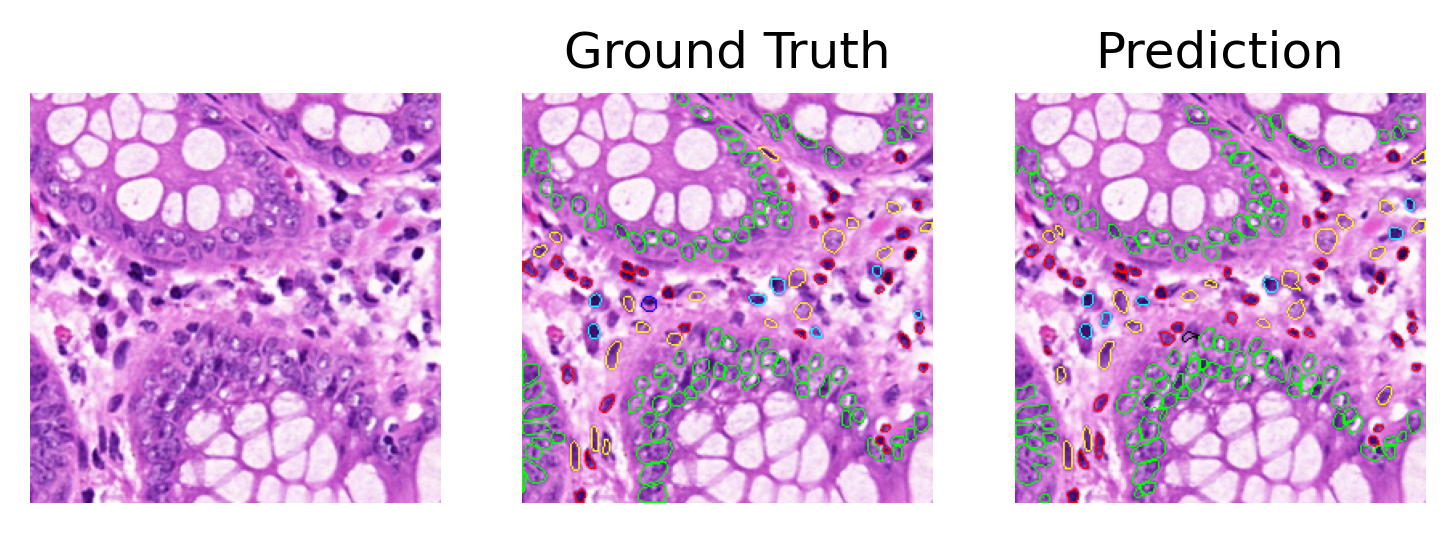

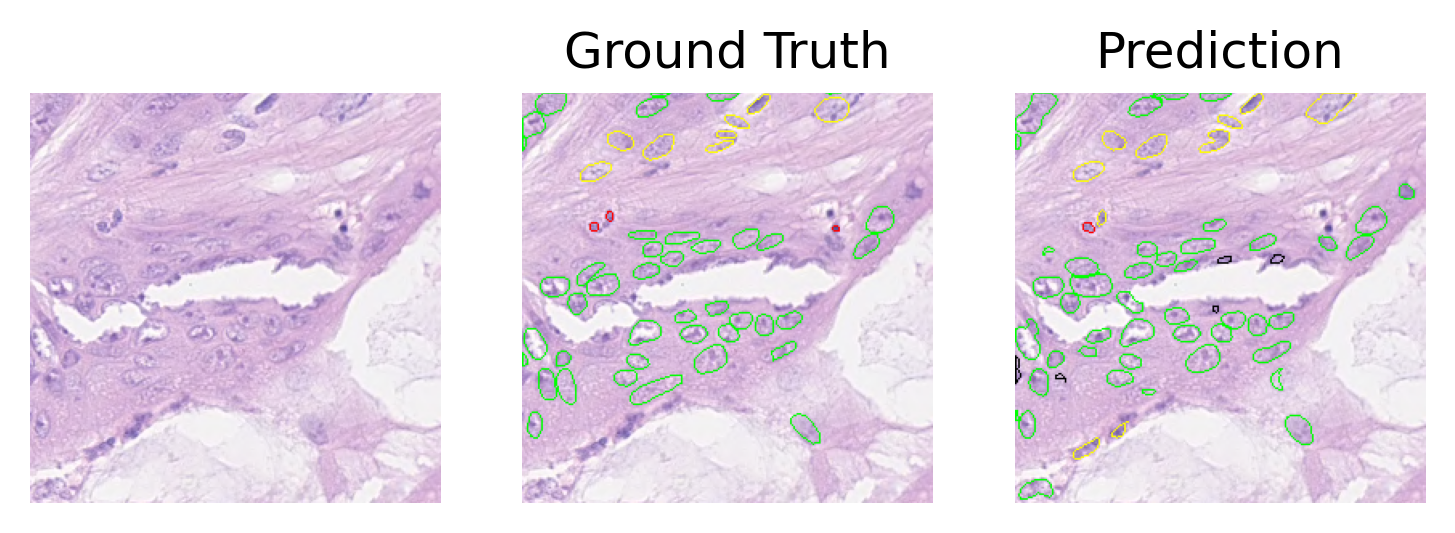

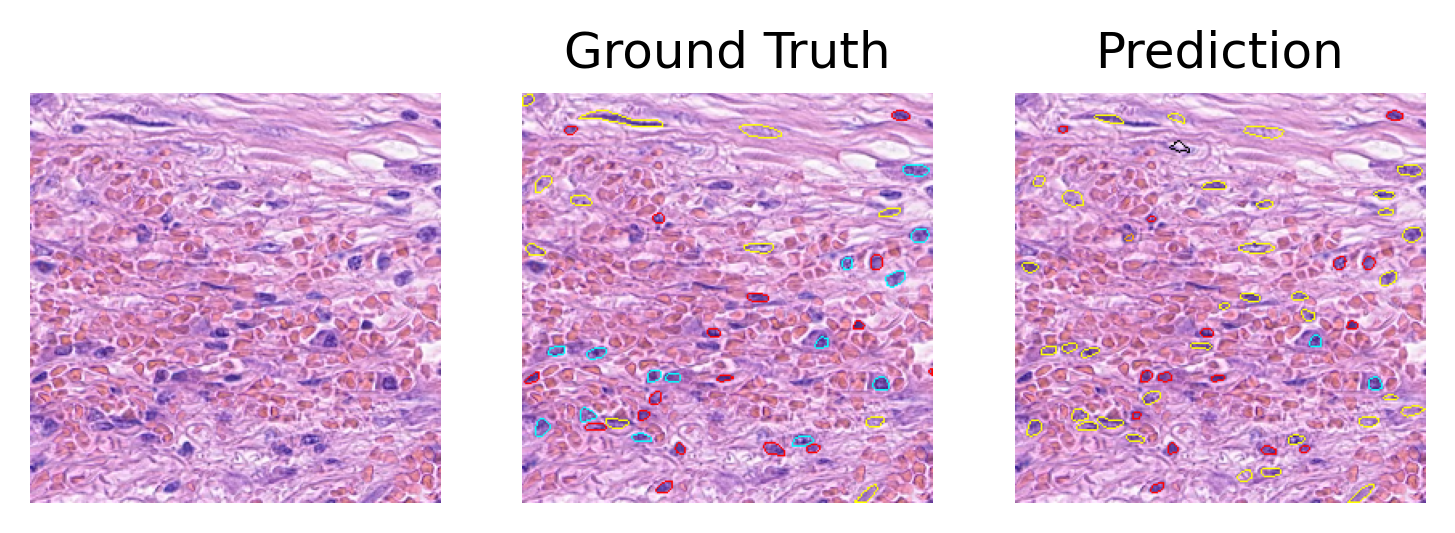

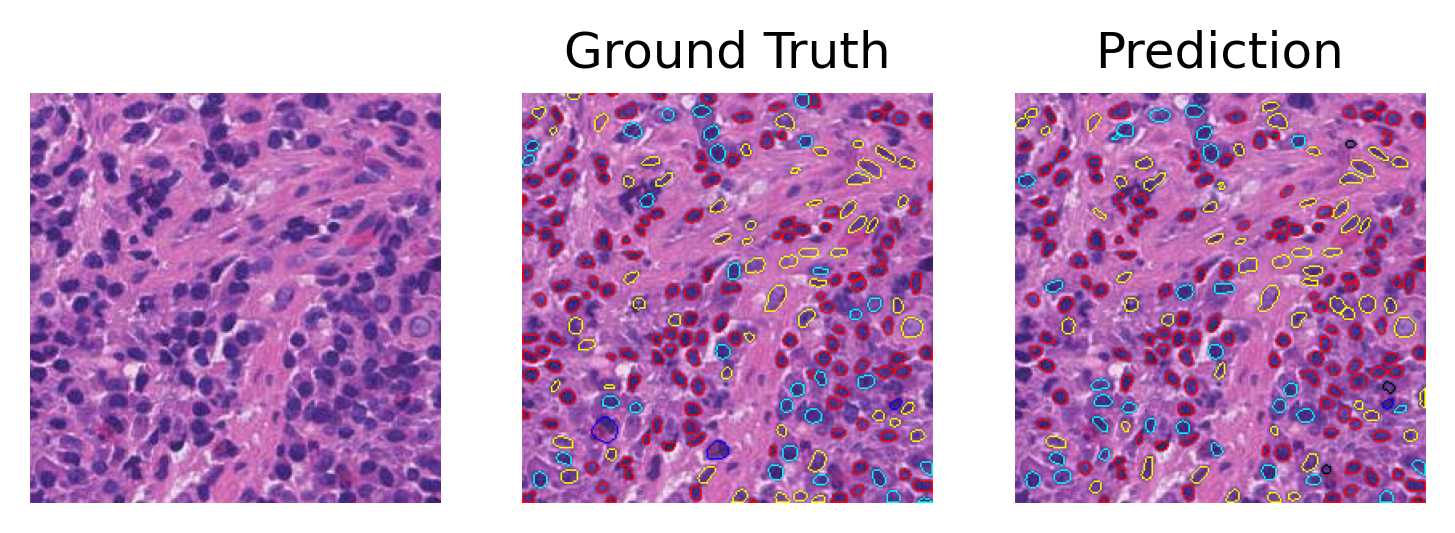

In [15]:
semantic_true = np.load(f'{OUT_DIR}/valid_true.npy')
semantic_pred = np.load(f'{OUT_DIR}/valid_pred.npy')

output_file = f'{OUT_DIR}/raw/file_map.dat'
output_info = joblib.load(output_file)

np.random.seed(SEED)
selected_indices = np.random.choice(len(valid_indices), 4)

PERCEPTIVE_COLORS = [
    (  0,   0,   0),
    (255, 165,   0),
    (  0, 255,   0),
    (255,   0,   0),
    (  0, 255, 255),
    (  0,   0, 255),
    (255, 255,   0),
]

for idx in selected_indices:
    img = cv2.imread(output_info[idx][0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    inst_map = semantic_pred[idx][..., 0]
    type_map = semantic_pred[idx][..., 1]
    pred_inst_dict = model._get_instance_info(inst_map, type_map)

    inst_map = semantic_true[idx][..., 0]
    type_map = semantic_true[idx][..., 1]
    true_inst_dict = model._get_instance_info(inst_map, type_map)

    inst_type_colours = np.array([
        PERCEPTIVE_COLORS[v['type']]
        for v in true_inst_dict.values()
    ])
    overlaid_true = overlay_prediction_contours(
        img, true_inst_dict,
        inst_colours=inst_type_colours,
        line_thickness=1
    )

    inst_type_colours = np.array([
        PERCEPTIVE_COLORS[v['type']]
        for v in pred_inst_dict.values()
    ])
    overlaid_pred = overlay_prediction_contours(
        img, pred_inst_dict,
        inst_colours=inst_type_colours,
        line_thickness=1
    )

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(overlaid_true)
    plt.title('Ground Truth')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(overlaid_pred)
    plt.title('Prediction')
    plt.axis('off')
    plt.show()